## Import required libraries.

In [1]:
%%capture
import operator
import seaborn as sns; sns.set()
from jupyterthemes import jtplot
jtplot.style()
import numpy as np
from landlab import FieldError
from landlab.utils import get_watershed_mask
import xarray as xr
import pandas as pd
import scipy
import gdal
from scipy import ndimage
from scipy.ndimage.filters import *
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.signal import medfilt
import os
import math
from osgeo import osr
from fractions import Fraction
import timeit
import matplotlib.pyplot as plt
#import matplotlib.image as mpimg
%matplotlib inline
import random
# import plotting tools
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib as mpl
from landlab.plot.imshow import imshow_grid 

# import necessary landlab components
from landlab import RasterModelGrid, HexModelGrid
from landlab.components import FlowAccumulator, LakeMapperBarnes, SinkFillerBarnes
from landlab.components import(FlowDirectorD8, 
                               FlowDirectorDINF, 
                               FlowDirectorMFD, 
                               FlowDirectorSteepest)
from landlab.components import DepressionFinderAndRouter
# import landlab plotting functionality
from landlab.plot.drainage_plot import drainage_plot
from pylab import show, figure

# create a plotting routine to make a 3d plot of our surface. 
def surf_plot(mg, surface='topographic__elevation', 
              title='Surface plot of topography', colormap = cm.gray):
    
    fig = plt.figure()
    ax = fig.gca(projection='3d')

    # Plot the surface.
    Z = (mg.at_node[surface].reshape(mg.shape))#[y1:y2, x1:x2]
    color = colormap((Z-Z.min())/(Z.max()-Z.min()))
    surf = ax.plot_surface(mg.node_x.reshape(mg.shape),#[y1:y2, x1:x2]
                           mg.node_y.reshape(mg.shape),#[y1:y2, x1:x2]
                           Z,
                           rstride=1, cstride=1,
                           facecolors=color,
                           linewidth=0.,
                           antialiased=False)
    ax.view_init(elev=35, azim=-120) 
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Elevation')
    plt.title(title)
    plt.show()

## Setup input data 
Define spatial resolution: Specify the resolution of the input DEM and also the desired working resolution (can be same as input DEM resolution).

In [2]:
def roundup(x):
    return int(math.ceil(x / 10.0)) * 10

input_DEM_resolution = 1
working_resolution = 1
location = (r'C:\PhD\junk')
os.chdir(location)
input_geotiff = gdal.Open('fann_sub.tif')
x = np.array(input_geotiff.GetRasterBand(1).ReadAsArray())
empty_grid_rows = roundup(x.shape[0])
empty_grid_cols = roundup(x.shape[1])
input_DEM = np.zeros([empty_grid_rows,empty_grid_cols])
input_DEM[:x.shape[0], :x.shape[1]] = x

input_outlets = gdal.Open('fann_gullies.tif')
o = np.array(input_outlets.GetRasterBand(1).ReadAsArray())
outlets= o
#outlets = 1 - o

## Visualise the DEM.

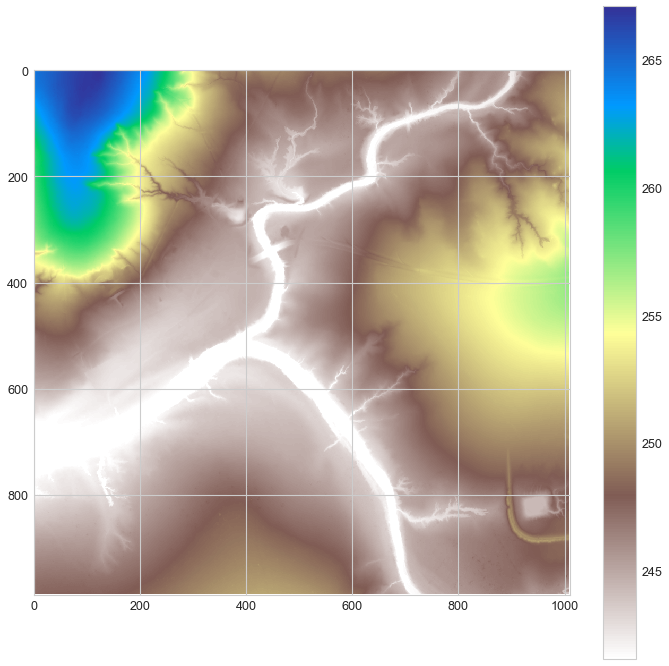

In [3]:
plt.figure(figsize=(12,12))
plt.imshow(input_DEM, cmap="terrain_r", vmin = np.percentile(input_DEM, 5));
plt.colorbar();

## Define required function.

In [4]:
def rectangleWindow(m, n):
    """Takes a value for number of rows (m) and number of columns (n) such that
       m and n are both positive real numbers and creates a rectangle of 
       boolian 'True' values."""
    rectangle = np.ones((m, n), dtype=bool) 
    return rectangle
def number_of_values(Window):
    """This funciton takes the shape function as an input and returns a number 
        of values present in the specified shape. 
        
        This can be different for a different window shape and to initialize
        requires the specification of the function for the given window type and 
        parameter values required for that input function.
        
        To initialize this function for shape == rectangle type 'number_of_values(rectangleWindow(m,n)) 
        where m and n are any positive real number as per the rectangleWindow function."""
    denominator = sum(sum(Window > 0))
    return denominator
def circleWindow(radius):
    """Takes a value for radius (r where r is any positive real number) and creates 
       a circular window using that radius."""
    y, x = np.ogrid[-radius: radius + 1, -radius: radius + 1]
    circle = x**2 + y**2 <= radius**2
    return circle
def find_median_value(Window):
    """This function takes the shape function and returns the median value 
        for all valid values (values that fall in the circle) arranged into a 
        1d array. The function also takes the number_of_values function as an input.
        To execute this function type 'find_median_value(shape(r)) where r is any integer.
        #Note: using median like this only gives the correct value for circles with odd 
        radius values."""
    no_values = number_of_values(Window)
    value_range = np.arange(0, no_values + 1)
    central_value = int(np.median(value_range))
    return central_value
def difference_from_mean_elevation(elev):
    """This function only works as an inside function to generic_filter function below. This
       is because generic_filter will take a 2d array and reshape it into a 1d array. Without this 
       step the 'central_value' variable will be outside of the array dimensions. 
       x = input DEM and r = radius of search window """
    centroid = elev[central_value]                        
    mean = np.nanmean(elev)#Count number of values greater than centroid value
    diff = centroid - mean
    return diff
def PCTL(x):
    """This function only works as an inside function to generic_filter function below. This
       is because generic_filter will take a 2d array and reshape it into a 1d array. Without this 
       step the 'central_value' variable will be outside of the array dimensions. 
       x = input DEM and r = radius of search window """
    centroid = x[central_value]                        
    y = np.sum(x < centroid)/num_values#Count number of values greater than centroid value
    return y
def flow_dir_dataset(flow_rec_prop, catchment_area, grid_resolution, outlet_node):
    """ Create an xarray Dataset containing eight arrays each representing the
    amount of water flowing in the given direction.
        1 . flow_rec_prop == the flow receiver proportion array created by LandLab flow routing.
        2 . catchment_area == the corresponding catchment area array from the landLab flow accumulation.
        surface.        
    The resulting Dataset is used to calculate specific catchment area."""
    array_direction = xr.Dataset()
    for i in range(0,8):
        rows = catchment_area.shape[0]; cols = catchment_area.shape[1];
        direction = np.flip(flow_rec_prop[:,i].reshape(rows,cols), 0);
        # Above needs to be flipped because during reshape it organises data top down
        # rather than bottom up as per ModelGrid order (catchment_area is mg arrangement).
        zero_outlet = outlet_node != 1
        remove_outlet = zero_outlet * catchment_area
        weighted_direction = xr.DataArray((remove_outlet * direction),
                                          dims = ['lat', 'lon']);
        array_direction[direction_list[i]] = weighted_direction
        
    E, N, W, S, NE, NW, SW, SE = (array_direction['East'], array_direction['North'],
                             array_direction['West'], array_direction['South'],
                             array_direction['North East'], array_direction['North West'],
                             array_direction['South West'], array_direction['South East'])

    flow_dirs = xr.concat([E, N, W, S, NE, NW, SW, SE], 'direction')
    flow_dirs.name = 'flow_directions'
    flow_dirs.attrs['grid cell resolution'] = grid_resolution
    flow_directions = flow_dirs.assign_coords(direction=(['East','North','West','South',
                                   'North East', 'North West','South West', 'South East']))
    return flow_directions
def profileCurvature(DEM, cellsize):
    """This process is taken from Change (2014, Introduction to Geographic Information
       systems, Page 284)."""
    Z1 = DEM[0]; Z2 = DEM[1]; Z3 = DEM[2]
    Z4 = DEM[3]; Z0 = DEM[4]; Z5 = DEM[5]
    Z6 = DEM[6]; Z7 = DEM[7]; Z8 = DEM[8]
    D = (((Z4 + Z5)/2) - Z0) / cellsize**2
    E = (((Z2 + Z7)/2) - Z0) / cellsize**2
    F = (Z3 - Z1 + Z6 - Z8)/ (4 * cellsize**2)
    G = (Z5 - Z4) / (2 * cellsize)
    H = (Z2 - Z7) / (2 * cellsize)
    profile_curvature = (-2 * (D*(G**2) + E*(H**2) + (F*G*H))) / (G**2 + H**2)
    return profile_curvature
def slopeWindowDegrees(DEM, x_cellsize, y_cellsize):
    """This function implements slope calculation using the same algorithm
       as ARCGIS (Outlined on the page 'How Slope Works').
       This particular example of the function is written such that it
       will only work if called within the ndimage generic_filter (as the first input).
       This is because the index arguments for a-e are given for the 1d array created
       by the generic_filter function after extracting values from the 3,3 rectangle window.
       NOTE: THIS FUNCTION ONLY WORKS WITH A 3x3 RECTANGLE WINDOW."""
    a = DEM[0]; b = DEM[1]; c = DEM[2]
    d = DEM[3]; e = DEM[4]; f = DEM[5]
    g = DEM[6]; h = DEM[7]; i = DEM[8]
    dzdx = ((c + (2*f) + i) - (a + (2*d) + g)) / (8 * x_cellsize)
    dzdy = ((g + (2*h) + i) - (a + (2*b) + c)) / (8 * y_cellsize)
    rise_run = np.sqrt(dzdx**2 + dzdy**2)
    slope_degrees = np.arctan(rise_run) * (180/math.pi)
    slope_percent = rise_run * 100
    #Can also ask it to return slope_degrees but asking for both causes it to throw and error.
    return slope_degrees
def closest(lst, K): 
     angle_list = lst
     idx = (np.abs(angle_list - K)).argmin() 
     return angle_list[idx]  
def data_range(data):
    data_min = np.amin(data); data_max = np.amax(data)
    value_range = data_max - data_min
    return value_range
def checkGullyHead(catchment_area_list, step_size, comparison_distance):
    
    """ """
    
    max_value_length = len(catchment_area_list) - step_size - comparison_distance - step_size
    for i in range(0, max_value_length):
                
        start_of_downstream_nodes = i
        end_of_downstream_nodes = i + step_size       
        downstream_nodes = catchment_area_list[start_of_downstream_nodes:end_of_downstream_nodes]
        
        start_of_upstream_nodes = i + step_size + comparison_distance
        end_of_usptreat_nodes = start_of_upstream_nodes + step_size
        upstream_nodes = catchment_area_list[start_of_upstream_nodes:end_of_usptreat_nodes]
        
        min_downstream = np.min(downstream_nodes)
        mean_upstream = np.sqrt(np.mean(upstream_nodes)**2)
        
        if min_downstream <= -0.2 and mean_upstream <= 0.1:
            keep_gully = 'yes'
            gully_head_location = end_of_downstream_nodes + np.round(comparison_distance/2) - 1
            break
        else:
            keep_gully = 'no'
            gully_head_location = 'none'

    return keep_gully, gully_head_location


In [5]:
#################################################################################################
flow_acc_surf = np.copy(input_DEM).astype('float64');
#################################################################################################
rows = flow_acc_surf.shape[0];
cols = flow_acc_surf.shape[1];
mg = RasterModelGrid((rows,cols), 1);
z1 = mg.add_field('topographic__elevation', flow_acc_surf, at = 'node');

sfb = SinkFillerBarnes(mg, method = 'Steepest', ignore_overfill = True);
sfb.run_one_step();
fa = FlowAccumulator(mg,
                    surface = 'topographic__elevation',
                    flow_director = 'FlowDirectorMFD',
                    diagonals = True);
#(flow_acc, q) = fa.accumulate_flow();
fa.run_one_step()
fd = FlowDirectorMFD(mg, 'topographic__elevation', diagonals = True);
fd.run_one_step()

da = np.array(mg.at_node['drainage_area'].round(4));
catchment_area_ha = np.divide(da.reshape(mg.shape), (100/working_resolution)**2)
frn = mg.at_node['flow__receiver_node'];
drainage_area = np.flip(da.reshape(mg.shape), 0);
frp = np.array(mg.at_node['flow__receiver_proportions']);
ns = np.flip(mg.status_at_node.reshape(mg.shape), 0);
flow_rec_surf_rows = cols * rows;
flow_rec_surf = frp.reshape(flow_rec_surf_rows,8);

tss = mg.at_node['topographic__steepest_slope'];
steepest_slope = tss.reshape(flow_rec_surf_rows,8);
all_receiver_proportions = np.copy(frp);

# For all nodes

In [6]:
# Must be larger than 'line_length' (specified later).
size_of_edge = 30

In [7]:

grid_nodes = np.array(mg.nodes.reshape(mg.shape))
find_nodes = np.multiply(outlets, grid_nodes);

gully_head_edge_mask = np.zeros([grid_nodes.shape[0], grid_nodes.shape[1]])
gully_head_mask_centre = np.ones([grid_nodes.shape[0] - size_of_edge*2, grid_nodes.shape[1] - size_of_edge*2])
gully_head_edge_mask[size_of_edge:-1*(size_of_edge), size_of_edge:-1*(size_of_edge)] = gully_head_mask_centre

remaining_gully_heads = find_nodes * gully_head_edge_mask
gh_array = np.unique(remaining_gully_heads);
gh_list = gh_array.tolist();
gh_list.remove(0);
len(gh_list)

108

# For one node

In [8]:
#grid_nodes = np.array(mg.nodes.reshape(mg.shape))
#find_outlet_ids = grid_nodes * outlets
#outlet_id = np.unique(find_outlet_ids)[1]


In [9]:
radius = 9
central_value = find_median_value(circleWindow(radius))
num_values = number_of_values(circleWindow(radius))
dfme = generic_filter(input_DEM, difference_from_mean_elevation, 
                        footprint= circleWindow(radius), mode='nearest');
dfme[dfme > 5.0] = 5.0
dfme[dfme < -5.0] = -5.0

In [10]:
slope = generic_filter(input_DEM, slopeWindowDegrees,
                  footprint= rectangleWindow(3,3),
                  mode='constant', extra_arguments = (input_DEM_resolution,input_DEM_resolution,));

In [11]:
# Specific the size of the area to be checked. This represents a physical distance from the 
# outlet but has no unit of measure.
distance_from_outlet = 20

In [12]:
#outlet_id = gh_list[10]
#outlet_id

In [13]:
#gully_heads_dict = {}


#for i in gh_list:

# This value is used to initialise the search.
catchment_outlet_id = 669667
# Initate an outer loop that iterates through every distance interval from the outlet.
watershed_grid_cells = []
node_location = mg.nodes.reshape(da.shape)
ordered_node_list = []

for i in range(0, distance_from_outlet):
    # Create a list initially containing only the outlet grid cell.
    if i == 0:
        candidate_gridcells = [catchment_outlet_id];
    else:
        candidate_gridcells = list(set(upstream_nodes));
    # Empty the list of upsteam nodes.
    upstream_nodes = {};
    # Intiate a new loop to check every gridcell at the current interval distance.
    print(candidate_gridcells)
    for grid_cell in candidate_gridcells:
        # Check each flow direction of the current grid cell.The second dimension of the 
        # flow__receiver_node object will always be size == 8.
        for i in range(frn.shape[1]):
            # Return all rows (grid nodes) that send any flow to the target grid cell.
            # Note: This can only be one grid cell because the prgram is looping through
            # each direction one at a time so only one grid cell can be sending flow from any
            # one given direction.
            flow_from_whole_grid_cell = frn[np.where(frn[:,i] == grid_cell)];
            # Check if the current direction contributes flow. If not, do nothing. 
            # Else, append to list.
            if flow_from_whole_grid_cell.shape[0] == 0:
                pass
            else:
                # Below variable finds the row position of the flow_from_direction gridcell
                # in the flow__receiver_node array. This corresponds to the contributing
                # cell's node id.
                node_id_value = np.where(np.all(flow_from_whole_grid_cell==frn,axis=1))[0][0];
                #Find the proportion of flow leaving the donor node and heading toward 
                # the current grid cell.
                proportion_of_flow = frp[node_id_value, i]
                # Create a boolean array to use as mask on drainage area.
                isolate_candidate_grid_cells = np.isin(node_location, node_id_value)
                node_drainage_area = np.amax(np.multiply(isolate_candidate_grid_cells, da))
                node_directional_drainage_area = node_drainage_area * proportion_of_flow
                upstream_nodes.update({node_id_value:node_directional_drainage_area});
        if len(upstream_nodes) == 0:
            print ("dictionary empty")
        else:
            primary_flow_direction_id = max(upstream_nodes.items(), key=operator.itemgetter(1))[0]
            upstream_nodes = []
            upstream_nodes.append(primary_flow_direction_id);
            ordered_node_list.append(primary_flow_direction_id);
            watershed_grid_cells.append(primary_flow_direction_id)

preliminary_width = np.isin(node_location,watershed_grid_cells)
flow_width = (preliminary_width * da).reshape(mg.shape)

flow_width[flow_width==0] = np.nan

flow_grid_nodes = (preliminary_width * da).reshape(mg.shape)

drainage_mask = flow_width > 0

drainage_slope = np.copy(slope).astype('float32')
drainage_slope[~drainage_mask] = np.nan

drainage_dfme = np.copy(dfme).astype('float32')
drainage_dfme[~drainage_mask] = np.nan

drainage_area = np.copy(catchment_area_ha).astype('float32')
drainage_area[~drainage_mask] = np.nan

drainage_nodes = np.copy(grid_nodes).astype('float32')
drainage_nodes[~drainage_mask] = np.nan

lat = grid_nodes.shape[0]
lon = grid_nodes.shape[1]
nodes_1d = np.squeeze(grid_nodes.reshape(1, lat * lon))
drainage_dfme_1d = np.squeeze(drainage_dfme.reshape(1, lat * lon))
drainage_slope_1d = np.squeeze(drainage_slope.reshape(1, lat * lon))
drainage_area_1d = np.squeeze(drainage_area.reshape(1, lat * lon))


node_drainage_dfme_dict = {}
for A, B in zip(nodes_1d, drainage_dfme_1d):
    node_drainage_dfme_dict[A] = B

dfme_from_gully_unordered = { key:value for key, value in node_drainage_dfme_dict.items() if ~np.isnan(value)}

# This just reorders the dictionary to reflect the actual node order along the flow line.
# The step above creates a dictionary where the keys are ordered from highest to lowest and this is not always
# going to reflect the node order (only if the flow line is moving south to north).
dfme_from_gully = {k: dfme_from_gully_unordered[k] for k in ordered_node_list}


node_drainage_slope_dict = {}
for A, B in zip(nodes_1d, drainage_slope_1d):
    node_drainage_slope_dict[A] = B

slope_from_gully_unordered = { key:value for key, value in node_drainage_slope_dict.items() if ~np.isnan(value) }
slope_from_gully = {k: slope_from_gully_unordered[k] for k in ordered_node_list}

node_drainage_area_dict = {}
for A, B in zip(nodes_1d, drainage_area_1d):
    node_drainage_area_dict[A] = B

area_from_gully_unordered = { key:value for key, value in node_drainage_area_dict.items() if ~np.isnan(value) }
area_from_gully = {k: area_from_gully_unordered[k] for k in ordered_node_list}


ds = [dfme_from_gully, slope_from_gully, area_from_gully]
d = {}
for k in dfme_from_gully.keys():
    d[k] = tuple(d[k] for d in ds)
d_ordered = {k: d[k] for k in ordered_node_list}

drainage_parameters = pd.DataFrame.from_dict(d_ordered)

drainage_parameters.rename(index={0:'DFME', 1: 'Slope', 2: 'Area'}, inplace=True)

drainage_parameters_transpose = drainage_parameters.T

drainage_parameters_transpose.insert(0, "Distance", 0);

for i in range(0, distance_from_outlet):
    drainage_parameters_transpose.iloc[i,0] = i

drainage_parameters_transpose['Node ID'] = drainage_parameters_transpose.index

algorithm_end_point = drainage_parameters_transpose['Distance'].max()
algorithm_start_point = drainage_parameters_transpose['Distance'].min()

gh = drainage_parameters_transpose.loc[drainage_parameters_transpose['Distance'] == algorithm_end_point,
                                                  'Node ID'].values[0]

cp = drainage_parameters_transpose.loc[drainage_parameters_transpose['Distance'] == algorithm_start_point,
                                                  'Node ID'].values[0]

node_length = np.abs(cp - gh)
length = node_length/mg.shape[0]

gh_lat = np.where(grid_nodes == gh)[0][0]
cp_lat = np.where(grid_nodes == cp)[0][0]
gh_lon = np.where(grid_nodes == gh)[1][0]
cp_lon = np.where(grid_nodes == cp)[1][0]

lat_displacement = cp_lat - gh_lat
lon_displacement = gh_lon - cp_lon

if lat_displacement > 0 and lon_displacement > 0:
    angle_max = 90
    angle_min = 0
    quadrant = 1
    print('Quadrant = Q1', 'min angle', str(angle_min), 'max angle', str(angle_max))
elif lat_displacement > 0 and lon_displacement < 0:
    angle_max = 360
    angle_min = 270
    quadrant = 2
    print('Quadrant = Q2', 'min angle', str(angle_min), 'max angle', str(angle_max))
elif lat_displacement < 0 and lon_displacement < 0:
    angle_max = 270
    angle_min = 180
    quadrant = 3
    print('Quadrant = Q3', 'min angle', str(angle_min), 'max angle', str(angle_max))
else:
    angle_max = 180
    angle_min = 90
    quadrant = 4
    print('Quadrant = Q4', 'min angle', str(angle_min), 'max angle', str(angle_max))

theta_a = np.degrees(np.arctan(np.abs(lat_displacement)/np.abs(lon_displacement)))

if quadrant == 1:
    gully_orientation = angle_max - theta_a
elif quadrant == 2:
    gully_orientation = angle_min + theta_a
elif quadrant == 3:
    gully_orientation = angle_max - theta_a
else:
    gully_orientation = angle_min + theta_a

class GullyOrientation:
    """Convention for first direction to take (d1) in cross section method 
    follows directional convention used in Landlab."""
    possible_angles = np.array([90, 0, 270, 180, 45, 315, 225, 135, 360])
    def __init__(self, angle, outlet, grid_shape):
        self.angle = angle
        self.outlet = outlet
        self.grid_shape = grid_shape
        idx = (np.abs(self.possible_angles - self.angle)).argmin() 
        find_angle_from_list = self.possible_angles[idx]
        self.closest_angle = find_angle_from_list

    def cross_section(self, line_length):
        cross_section_nodes_d1 = [self.outlet]
        cross_section_nodes_d2 = [self.outlet]
        if self.closest_angle == 90 or self.closest_angle == 270:
            print('east-west gully')
            for i in range(0, line_length):
                current_node_d1 = cross_section_nodes_d1[i]             
                current_node_d2 = cross_section_nodes_d2[i]
                next_node_d1 = current_node_d1 - self.grid_shape[1]
                next_node_d2 = current_node_d2 + self.grid_shape[1]
                cross_section_nodes_d1.append(next_node_d1)
                cross_section_nodes_d2.append(next_node_d2)

        elif self.closest_angle == 0 or self.closest_angle == 180 or self.closest_angle == 360:
            print('north-south gully')
            for i in range(0, line_length):
                current_node_d1 = cross_section_nodes_d1[i]             
                current_node_d2 = cross_section_nodes_d2[i]
                next_node_d1 = current_node_d1 + 1
                next_node_d2 = current_node_d2 - 1
                cross_section_nodes_d1.append(next_node_d1)
                cross_section_nodes_d2.append(next_node_d2)

        elif self.closest_angle == 45 or self.closest_angle == 225:
            print('northeast-southwest gully')
            for i in range(0, line_length):
                current_node_d1 = cross_section_nodes_d1[i]             
                current_node_d2 = cross_section_nodes_d2[i]
                next_node_d1 = current_node_d1 - (self.grid_shape[1] + 1)
                next_node_d2 = current_node_d2 + (self.grid_shape[1] + 1)
                cross_section_nodes_d1.append(next_node_d1)
                cross_section_nodes_d2.append(next_node_d2)
        else:
            print('northwest-southeast gully')
            for i in range(0, line_length):
                current_node_d1 = cross_section_nodes_d1[i]             
                current_node_d2 = cross_section_nodes_d2[i]
                next_node_d1 = current_node_d1 - (self.grid_shape[1] - 1)
                next_node_d2 = current_node_d2 + (self.grid_shape[1] - 1)
                cross_section_nodes_d1.append(next_node_d1)
                cross_section_nodes_d2.append(next_node_d2)

        cross_section_nodes = np.array(list(set(cross_section_nodes_d1 + cross_section_nodes_d2)))
        return cross_section_nodes

gully_and_cross_section = GullyOrientation(gully_orientation, catchment_outlet_id, mg.shape)

line_length = 20

cross_section_nodes = gully_and_cross_section.cross_section(line_length)

cross_section_mask = np.isin(node_location,cross_section_nodes).reshape(mg.shape)
cross_section_image = cross_section_mask.astype('uint8')

cross_section_slope = np.copy(slope).astype('float32')
cross_section_slope[~cross_section_mask] = np.nan

cross_section_dfme = np.copy(dfme).astype('float32')
cross_section_dfme[~cross_section_mask] = np.nan

cross_section_area = np.copy(catchment_area_ha).astype('float32')
cross_section_area[~cross_section_mask] = np.nan

cross_section_nodes = np.copy(grid_nodes).astype('float32')
cross_section_nodes[~cross_section_mask] = np.nan

cross_section_elevation_prep = np.copy(input_DEM).astype('float32')
cross_section_elevation_prep[~cross_section_mask] = np.nan
cross_section_elevation = cross_section_elevation_prep - np.nanmin(cross_section_elevation_prep)

cross_section_dfme_line = cross_section_elevation_prep - np.nanmean(cross_section_elevation_prep)

lat = grid_nodes.shape[0]
lon = grid_nodes.shape[1]
nodes_1d = np.squeeze(grid_nodes.reshape(1, lat * lon))
cross_section_dfme_1d = np.squeeze(cross_section_dfme.reshape(1, lat * lon))
cross_section_slope_1d = np.squeeze(cross_section_slope.reshape(1, lat * lon))

cross_section_area_1d = np.squeeze(cross_section_area.reshape(1, lat * lon))

cross_section_elevation_1d = np.squeeze(cross_section_elevation.reshape(1, lat * lon))
cross_section_dfme_line_1d = np.squeeze(cross_section_dfme_line.reshape(1, lat * lon))

node_cross_section_dfme_dict = {}
for A, B in zip(nodes_1d, cross_section_dfme_1d):
    node_cross_section_dfme_dict[A] = B

dfme_cross_section_unordered = { key:value for key, value in node_cross_section_dfme_dict.items() if ~np.isnan(value) }

node_cross_section_slope_dict = {}
for A, B in zip(nodes_1d, cross_section_slope_1d):
    node_cross_section_slope_dict[A] = B

slope_cross_section_unordered = { key:value for key, value in node_cross_section_slope_dict.items() if ~np.isnan(value)}

node_cross_section_area_dict = {}
for A, B in zip(nodes_1d, cross_section_area_1d):
    node_cross_section_area_dict[A] = B

area_cross_section_unordered = { key:value for key, value in node_cross_section_area_dict.items() if ~np.isnan(value) }

node_cross_section_elevation_dict = {}
for A, B in zip(nodes_1d, cross_section_elevation_1d):
    node_cross_section_elevation_dict[A] = B

elevation_cross_section_unordered = { key:value for key, 
                                     value in node_cross_section_elevation_dict.items() if ~np.isnan(value) }

node_cross_section_dfme_line_dict = {}
for A, B in zip(nodes_1d, cross_section_dfme_line_1d):
    node_cross_section_dfme_line_dict[A] = B

dfme_line_cross_section_unordered = { key:value for key, 
                                     value in node_cross_section_dfme_line_dict.items() if ~np.isnan(value) }

ds = [dfme_cross_section_unordered,  
      slope_cross_section_unordered, area_cross_section_unordered, 
     elevation_cross_section_unordered, dfme_line_cross_section_unordered]
d = {}
for k in dfme_cross_section_unordered.keys():
    d[k] = tuple(d[k] for d in ds)

cross_section_parameters = pd.DataFrame.from_dict(d)

cross_section_parameters.rename(index={0:'DFME', 1: 'Slope', 
                                       2: 'Area', 3: 'Elevation', 4: 'DFME Line'}, inplace=True)

cross_section_parameters_transpose = cross_section_parameters.T

cross_section_parameters_transpose.insert(0, "Distance", 0)

for i in range(0, (line_length * 2)+1):
    if i < line_length:
        cross_section_parameters_transpose.iloc[i,0] = -line_length + i
    else:
        cross_section_parameters_transpose.iloc[i,0] = i - line_length

cumulative_cross_section_parameters = cross_section_parameters_transpose.cumsum()

cross_section_parameters_transpose['Cumulative DFME'] = cumulative_cross_section_parameters.iloc[:,1]

cross_section_parameters_transpose['Cumulative S'] = cumulative_cross_section_parameters.iloc[:,3]
cross_section_parameters_transpose['Cumulative A'] = cumulative_cross_section_parameters.iloc[:,4]


extract_slope = cross_section_parameters_transpose['Slope'].values

cross_section_parameters_transpose['Slope Range'] = generic_filter(extract_slope, data_range, 
                                                                       footprint= (1, 3), mode='nearest');

extract_dfme = cross_section_parameters_transpose['DFME'].values

cross_section_parameters_transpose['DFME Range'] = generic_filter(extract_dfme, data_range, 
                                                                       footprint= (1, 3), mode='nearest');
dCDFMEdx = np.gradient(drainage_parameters_transpose.loc[:,'DFME'].values)
d2CDFMEdx2 = np.gradient(dCDFMEdx)

dCSdx = np.gradient(drainage_parameters_transpose.loc[:,'Slope'].values)
d2CSdx2 = np.gradient(dCSdx)

dCAdx = np.gradient(drainage_parameters_transpose.loc[:,'Area'].values)
d2CAdx2 = np.gradient(dCAdx)


drainage_parameters_transpose['dCDFMEdx'] = dCDFMEdx

drainage_parameters_transpose['dCSdx'] = dCSdx
drainage_parameters_transpose['dCAdx'] = dCAdx


drainage_parameters_transpose['d2CDFMEdx2'] = d2CDFMEdx2

drainage_parameters_transpose['d2CSdx2'] = d2CSdx2
drainage_parameters_transpose['d2CAdx2'] = d2CAdx2


cumulative_drainage_parameters = drainage_parameters_transpose.cumsum()
drainage_parameters_transpose['Cumulative DFME'] = cumulative_drainage_parameters.iloc[:,1]

get_median_slope = drainage_parameters_transpose.loc[:,'Slope'].values
get_median_dfme = drainage_parameters_transpose.loc[:,'DFME'].values

median_slope = ndimage.median_filter(get_median_slope, size=3)
median_dfme = ndimage.median_filter(get_median_dfme, size=3)

drainage_parameters_transpose['MedianSlope'] = median_slope
drainage_parameters_transpose['MedianDFME'] = median_dfme

dfme_list = drainage_parameters_transpose.loc[:,'MedianDFME'].values.tolist()

gully_head, distance_upstream = checkGullyHead(dfme_list,3,3)    

    #gully_heads_dict.update({catchment_outlet_id:gully_head});


[669667]
[668658]
[667647]
[666638]
[665628]
[664618]
[664619]
[664620]
[663611]
[662601]
[661592]
[660581]
[659571]
[658562]
[658563]
[657554]
[657555]
[657556]
[656547]
[656548]


C:\Users\sjwal\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in greater


Quadrant = Q1 min angle 0 max angle 90
northeast-southwest gully


In [14]:
gully_head

'no'

Text(0.5, 1.0, 'Change in upstream values for DFME and PC')

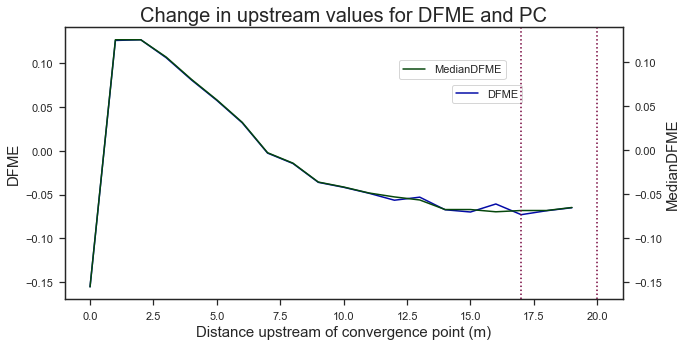

In [15]:
sns.set(style = 'ticks')
fig, ax1 = plt.subplots(figsize = (10, 5))
y1 = "DFME"
y2 = "MedianDFME"

sns.lineplot(data = drainage_parameters_transpose,x = "Distance",y = y1, color = 'xkcd:cobalt blue')
ax1.set_ylabel(y1, fontsize=15)
#ax1.lines[0].set_linestyle("--")
#ax1.set_ylim(-0.5, 0.5)
ax1.set_xlabel('Distance upstream of convergence point (m)', fontsize = 15)
ax1.legend([y1],bbox_to_anchor=(0.3, 0.21, 0.53, 0.6))
ax2 = ax1.twinx()

#ax2.set_ylim(-0.3,0.3)
sns.lineplot(data=drainage_parameters_transpose,x = "Distance",y=y2,color='xkcd:forest green',ax = ax2)
ax2.set_ylabel(y2, fontsize = 15)
ax2.legend([y2],bbox_to_anchor=(0.3, 0.5, 0.5, 0.4))
plt.axvline(x=17, color = 'xkcd:merlot', linestyle = 'dotted')
plt.axvline(x=20, color = 'xkcd:merlot', linestyle = 'dotted')
#ax1.text(18, -0.8, r'Gully head', fontsize=15, rotation = 90)
plt.title('Change in upstream values for DFME and PC', fontsize = 20)

In [16]:
gully_head, distance_upstream = checkGullyHead(dfme_list,3,3)    


In [17]:
gully_head

'no'

In [18]:
dfme_list

[-0.1551206111907959,
 0.12574417889118195,
 0.12574417889118195,
 0.10610159486532211,
 0.08070246875286102,
 0.0573868565261364,
 0.031879350543022156,
 -0.0026682978495955467,
 -0.014514666981995106,
 -0.0359964482486248,
 -0.041646722704172134,
 -0.04844900593161583,
 -0.05289570987224579,
 -0.05637278035283089,
 -0.06725230067968369,
 -0.06725230067968369,
 -0.06980763375759125,
 -0.06835237890481949,
 -0.06835237890481949,
 -0.0649125799536705]

In [ ]:
gully_head

In [ ]:
distance_upstream

To find the endpoints of the line at the head of the gully, all i need to do is move n units in the direction of the gully orientation from the end points of the cross section line. Can use same rules from the GullOrientation class.

Note: Method below requires that the outlet_id (A) is at least 10 grid cells from the edge of the DEM. In the paper can just say gullies near edges were not used because it risks moving window values being affected.

## Scheme for finding all grid cells along the desired line.

Four possible line: 

(1) north-south, north direction == outlet_id - mg.shape[1], south direction == outlet_id + mg.shape[1]

(2) east-west, east = outlet_id + 1, west == outlet_id - 1

(3) northeast-southwest, northeast == outlet_id - (mg.shape[1] - 1), southwest == outlet_id + (mg.shape[1] - 1)

(4) northwest-southeast, northwest == outlet_id - (mg.shape[1] + 1), southeast == outlet_id + (mg.shape[1] + 1)


# Calculate the cumulative summary of each variable.

In [20]:
cross_section_parameters_transpose

,Distance,DFME,Slope,Area,Elevation,DFME Line,Cumulative DFME,Cumulative S,Cumulative A,Slope Range,DFME Range
649447,-20,0.018608,2.841651,0.006651,1.497360,0.800598,0.018608,0.006651,1.497360,0.000000,0.000000
650458,-19,0.019685,2.920783,0.006179,1.437119,0.740356,0.038294,0.012830,2.934479,0.079132,0.001077
651469,-18,0.027426,3.070561,0.004550,1.382477,0.685715,0.065720,0.017380,4.316956,0.149778,0.007741
652480,-17,0.015088,3.277720,0.005257,1.306137,0.609375,0.080808,0.022638,5.623093,0.207159,0.012339
653491,-16,0.003892,3.529001,0.005421,1.228958,0.532196,0.084700,0.028059,6.852051,0.251280,0.011195
654502,-15,-0.016427,3.739773,0.005183,1.141129,0.444366,0.068273,0.033241,7.993179,0.210773,0.020320
655513,-14,-0.035124,3.192065,0.005060,1.054352,0.357590,0.033149,0.038302,9.047531,0.547709,0.018696
656524,-13,-0.046016,3.035156,0.005353,0.975601,0.278839,-0.012866,0.043655,10.023132,0.156908,0.010892
657535,-12,-0.052525,3.014138,0.005429,0.901321,0.204559,-0.065392,0.049084,10.924454,0.021018,0.006510
658546,-11,-0.042765,2.275209,0.005174,0.842010,0.145248,-0.108157,0.054257,11.766464,0.738929,0.009760


In [21]:
dCDFMEdx = np.gradient(cross_section_parameters_transpose.loc[:,'DFME'].values)
d2CDFMEdx2 = np.gradient(dCDFMEdx)
 
dCSdx = np.gradient(cross_section_parameters_transpose.loc[:,'Slope'].values)
d2CSdx2 = np.gradient(dCSdx)

dCAdx = np.gradient(cross_section_parameters_transpose.loc[:,'Area'].values)
d2CAdx2 = np.gradient(dCAdx)


cross_section_parameters_transpose['dCDFMEdx'] = dCDFMEdx
cross_section_parameters_transpose['dCSdx'] = dCSdx
cross_section_parameters_transpose['dCAdx'] = dCAdx


cross_section_parameters_transpose['d2CDFMEdx2'] = d2CDFMEdx2
cross_section_parameters_transpose['d2CSdx2'] = d2CSdx2
cross_section_parameters_transpose['d2CAdx2'] = d2CAdx2


In [22]:
cross_section_parameters_transpose_spline = pd.DataFrame(np.arange(-100,100)/(100.0/line_length), columns = ['Distance']) 

In [23]:
spline_smoothness = np.linspace(-line_length,line_length, 200)
spline_input_distance = cross_section_parameters_transpose.loc[:,'Distance'].values

spline_input_dfme = cross_section_parameters_transpose.loc[:,'DFME'].values
dfme_spline_setup = InterpolatedUnivariateSpline(spline_input_distance, spline_input_dfme)
dfme_spline = dfme_spline_setup(spline_smoothness)

spline_input_dfme = cross_section_parameters_transpose.loc[:,'Cumulative DFME'].values
cdfme_spline_setup = InterpolatedUnivariateSpline(spline_input_distance, spline_input_dfme)
cdfme_spline = cdfme_spline_setup(spline_smoothness)

spline_input_slope = cross_section_parameters_transpose.loc[:,'Slope'].values
slope_spline_setup = InterpolatedUnivariateSpline(spline_input_distance, spline_input_slope)
slope_spline = slope_spline_setup(spline_smoothness)

spline_input_slope_range = cross_section_parameters_transpose.loc[:,'Slope Range'].values
slope_range_spline_setup = InterpolatedUnivariateSpline(spline_input_distance, spline_input_slope_range)
slope_range_spline = slope_range_spline_setup(spline_smoothness)

spline_input_area = cross_section_parameters_transpose.loc[:,'Area'].values
area_spline_setup = InterpolatedUnivariateSpline(spline_input_distance, spline_input_area)
area_spline = area_spline_setup(spline_smoothness)

spline_input_dfme_range = cross_section_parameters_transpose.loc[:,'DFME Range'].values
dfme_range_spline_setup = InterpolatedUnivariateSpline(spline_input_distance, spline_input_dfme_range)
dfme_range_spline = dfme_range_spline_setup(spline_smoothness)

spline_input_dfme_line = cross_section_parameters_transpose.loc[:,'DFME Line'].values
dfme_line_spline_setup = InterpolatedUnivariateSpline(spline_input_distance, spline_input_dfme_line)
dfme_line_spline = dfme_line_spline_setup(spline_smoothness)

spline_input_elevation_range = cross_section_parameters_transpose.loc[:,'Elevation'].values
elevation_range_spline_setup = InterpolatedUnivariateSpline(spline_input_distance, spline_input_elevation_range)
elevation_range_spline = elevation_range_spline_setup(spline_smoothness)

spline_input_d2CDFMEdx2 = cross_section_parameters_transpose.loc[:,'d2CDFMEdx2'].values
d2CDFMEdx2_spline_setup = InterpolatedUnivariateSpline(spline_input_distance, spline_input_d2CDFMEdx2)
d2CDFMEdx2_spline = d2CDFMEdx2_spline_setup(spline_smoothness)

spline_input_dCDFMEdx = cross_section_parameters_transpose.loc[:,'dCDFMEdx'].values
dCDFMEdx_spline_setup = InterpolatedUnivariateSpline(spline_input_distance, spline_input_dCDFMEdx)
dCDFMEdx_spline = dCDFMEdx_spline_setup(spline_smoothness)

spline_input_dCSdx = cross_section_parameters_transpose.loc[:,'dCSdx'].values
dCSdx_spline_setup = InterpolatedUnivariateSpline(spline_input_distance, spline_input_dCSdx)
dCSdx_spline = dCSdx_spline_setup(spline_smoothness)

cross_section_parameters_transpose_spline['DFMEL Spline'] = dfme_line_spline
cross_section_parameters_transpose_spline['Elevation Spline'] = elevation_range_spline
cross_section_parameters_transpose_spline['DFMER Spline'] = dfme_range_spline
cross_section_parameters_transpose_spline['DFME Spline'] = dfme_spline
cross_section_parameters_transpose_spline['Cumulative DFME Spline'] = cdfme_spline

cross_section_parameters_transpose_spline['A Spline'] = area_spline
cross_section_parameters_transpose_spline['Slope Spline'] = slope_spline
cross_section_parameters_transpose_spline['SR Spline'] = slope_range_spline
cross_section_parameters_transpose_spline['d2CDFMEdx2 Spline'] = d2CDFMEdx2_spline

cross_section_parameters_transpose_spline['dCDFMEdx Spline'] = dCDFMEdx_spline

cross_section_parameters_transpose_spline['dCSdx Spline'] = dCSdx_spline

# Possible rules
1. Find peak in second derivative of DFME and then the first point it cross the x-axis.
2. Find point that PC goes from large negative to positive and then point that it crosses x-axis.
3. Some combination of 1 & 2. E.g. condition 1 only if first part of condition 2 is also met.

Probably just the first is best but can still talk about considering PC and show graph.

## Can use DFME together with one of slope, pc, area and then use a sum of squares approach to test which of the three models works best on all ~30 gullies.

# Three possible rules:

Just have set maximum distance same as flow line. For edges can be 15m in each direction. The the edge will always just be the maximum DFME or rate of change of DFME (second derivative?).

1. Find peak DFME.

2. Combination DFME and Slope Range. Just look for peak DFME followed by sections of low slope range (<5?) and DFME is within delta of the 0 line.

3. Combined DFME, PC and Slope. Look for DFME peak precded by clear - to + PC change and followed by low slope range (<5?) and DFME is within delta of the 0 line.

Increasing complexity, least squares will see if complexity is needed or not.

Then digitise edges for sample of 30 and do least squares assessment of the three methods.

# Maybe the simplest rule is to find spots where slope is low and DFME is 0.
# Or just find peak in DFME.

Text(0.5, 1.0, 'Gully cross section DFME and slope')

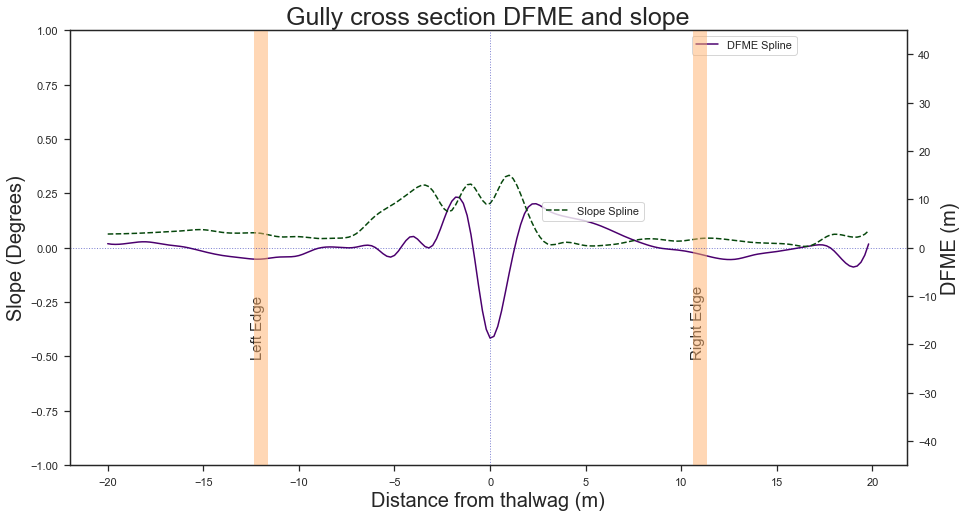

In [24]:
sns.set(style = 'ticks')
fig, ax1 = plt.subplots(figsize = (15, 8))
x_value = "Distance"
y1_value = "DFME Spline"
y2_value = "Slope Spline"
sns.lineplot(data = cross_section_parameters_transpose_spline, x = x_value, y = y1_value, 
             color = 'xkcd:royal purple')
ax1.set_ylabel('Slope (Degrees)', fontsize=20)
#ax1.annotate('Thalweg', arrowprops = dict(facecolor = 'black'), xy = (0, -23), xytext = (1, -29))
#ax1.lines[0].set_linestyle("--")
ax1.set_ylim(-1, 1)
ax1.set_xlabel('Distance from thalwag (m)', fontsize = 20)
ax1.legend([y1_value],bbox_to_anchor=(0.375, 0.6, 0.5, 0.4))
ax2 = ax1.twinx()
ax2.set_ylim(-45, 45)
sns.lineplot(data = cross_section_parameters_transpose_spline, x = x_value, y = y2_value
             , color = 'xkcd:forest green', ax = ax2)
ax2.lines[0].set_linestyle("--")
#ax2.set_ylabel(y2_value, fontsize = 15)
ax2.set_ylabel('DFME (m)', fontsize = 20)
ax2.legend([y2_value],bbox_to_anchor=(0.375, 0.55, 0.5, 0.4))
plt.axvline(x=11, color = 'xkcd:apricot', linewidth = 14, alpha = 0.5)
plt.axvline(x=-12, color = 'xkcd:apricot', linewidth = 14, alpha = 0.5)
plt.axvline(x=0, color = 'xkcd:cobalt blue', linewidth = 1, alpha = 0.5, linestyle = 'dotted')
plt.axhline(y=0, color = 'xkcd:cobalt blue', linewidth = 1, alpha = 0.5, linestyle = 'dotted')
#plt.axvline(x=0, color = 'xkcd:cobalt blue', alpha = 0.5, linestyle = 'dotted')
#plt.axvline(x=11, color = 'xkcd:pumpkin', linestyle = 'dotted')
ax1.text(-12.5, -0.5, r'Left Edge', fontsize=15, rotation = 90)
ax1.text(10.5, -0.5, r'Right Edge', fontsize=15, rotation = 90)
plt.title('Gully cross section DFME and slope', fontsize = 25)

# 

## Second derivative works best because the highest rate is the middle of the wall going up and the point that then crosses the x-axis when the increase stops being positive (immediately after passing up over the edge of the gully) - straight from graph theory. 

## First derivative.

In [ ]:
sns.set(style = 'ticks')
fig, ax1 = plt.subplots(figsize = (10, 5))
sns.lineplot(data = cross_section_parameters_transpose_spline, x = "Distance", y = "d2CDFMEdx2 Spline", 
             color = 'xkcd:royal purple')
ax1.set_ylabel('DFME (m)', fontsize=15)
#ax1.annotate('Transition', arrowprops = dict(facecolor = 'black'), xy = (15.5, 0), xytext = (7, 0.06))
#ax1.lines[0].set_linestyle("--")
#ax1.set_ylim(-0.5, 0.5)
ax1.set_xlabel('Distance downstream (m)', fontsize = 15)
ax1.legend(['DFME'],bbox_to_anchor=(0.4, 0.6, 0.5, 0.4))
ax2 = ax1.twinx()
#ax2.set_ylim(-0.2, 0.2)
sns.lineplot(data = cross_section_parameters_transpose_spline, x = "Distance", y = "S Spline", 
             color = 'xkcd:forest green', ax = ax2)
ax2.lines[0].set_linestyle("--")
ax2.set_ylabel('PC (rad / 100m)', fontsize = 15)
ax2.legend(['PC'],bbox_to_anchor=(0.375, 0.5, 0.5, 0.4))
plt.axvline(x=7, color = 'xkcd:apricot', linewidth = 14, alpha = 0.5)
plt.axhline(y=0, color = 'xkcd:cobalt blue', alpha = 0.5, linestyle = 'dotted')
#plt.axvline(x=6.5, color = 'xkcd:pumpkin', linestyle = 'dotted')
ax1.text(11.5, -0.075, r'Gully head', fontsize=15, rotation = 90)
plt.title('Second derivative of DFME and PC cumulative upstream sum', fontsize = 20)

In [ ]:
sns.set(style = 'ticks')
fig, ax1 = plt.subplots(figsize = (10, 5))
sns.lineplot(data = cross_section_parameters_transpose_spline, x = "Distance", y = "S Spline", 
             color = 'xkcd:forest green')
ax1.set_ylabel('DFME (m)', fontsize=15)
#ax1.annotate('Transition', arrowprops = dict(facecolor = 'black'), xy = (15.5, 0), xytext = (7, 0.06))
ax1.lines[0].set_linestyle("--")
#ax1.set_ylim(-0.4, 0.4)
ax1.set_xlabel('Distance downstream (m)', fontsize = 15)
ax1.legend(['DFME'],bbox_to_anchor=(0.4, 0.6, 0.5, 0.4))
ax2 = ax1.twinx()
ax2.set_ylim(-0.6, 0.6)
sns.lineplot(data = cross_section_parameters_transpose_spline, x = "Distance", y = "d2CDFMEdx2 Spline", 
             color = 'xkcd:royal purple', ax = ax2)
#ax2.lines[0].set_linestyle("--")
ax2.set_ylabel('PC (rad / 100m)', fontsize = 15)
ax2.legend(['PC'],bbox_to_anchor=(0.375, 0.5, 0.5, 0.4))
plt.axvline(x=3, color = 'xkcd:apricot', linewidth = 14, alpha = 0.5)
plt.axvline(x=-4, color = 'xkcd:apricot', linewidth = 14, alpha = 0.5)
plt.axhline(y=0, color = 'xkcd:cobalt blue', alpha = 0.5, linestyle = 'dotted')
#plt.axvline(x=6.5, color = 'xkcd:pumpkin', linestyle = 'dotted')
ax1.text(-4.5, 35, r'L. edge', fontsize=15, rotation = 90)
ax1.text(2.5, 35, r'R. edge', fontsize=15, rotation = 90)
plt.title('Second derivative of DFME and PC cumulative upstream sum', fontsize = 20)

In [ ]:
# Extract the data we're interested in
dfme, dist = cross_section_parameters_transpose['DFME'], cross_section_parameters_transpose['Distance']
pc, slope = cross_section_parameters_transpose['PC'], cross_section_parameters_transpose['Slope']

# Scatter the points, using size and color but no label
plt.scatter(dist, dfme, label=None,
            c=pc, cmap='viridis',
            s=slope, linewidth=0, alpha=0.5)
plt.axis(aspect='equal')
plt.xlabel('Distance')
plt.ylabel('Difference from mean elevation')
plt.colorbar(label='slope')
plt.clim(-0.1, 0.1)

# Here we create a legend:

# we'll plot empty lists with the desired size and label
for slope in [1, 2, 5]:
    plt.scatter([], [], c='k', alpha=0.3, s=slope,
                label=str(slope) + ' ha')
plt.legend(scatterpoints=1, frameon=False, labelspacing=1, title='Gully plot')

plt.title('California Cities: Area and Population');

In [ ]:
cross_section_parameters_transpose_spline.head()

In [ ]:
cross_section_parameters_transpose['PC'].nunique()

In [ ]:
sns.set(style="white")

f = sns.relplot(x="Distance", y="DFME", hue="PC", size="Slope",
            sizes=(20, 200), alpha=.5, height=6, data=cross_section_parameters_transpose)

plt.axhline(y=0, color = 'xkcd:black', alpha = 0.2, linestyle = '--')
plt.axvline(x=0, color = 'xkcd:black', alpha = 0.2, linestyle = '--')
f.set(ylim = (-0.5, 0.5))

## Organise one field of the dataframe into categories so that I can use the palettes in below plot. n_colors below refers to the number of categories assigned to 'name'.

In [ ]:
bins = [-0.2, -0.1, -0.05, -0.01, 0, 0.01, 0.05, 0.1, 0.2]
names = ['- 0.2','- 0.1', '- 0.05', '- 0.01', '0.01', '0.05','0.1', '0.2']

cross_section_parameters_transpose['Profile Curvature'] = pd.cut(cross_section_parameters_transpose['PC'], 
                                                                 bins, labels=names)

In [ ]:
filtered_pc = np.copy(cross_section_parameters_transpose['PC'].values)
filtered_pc[filtered_pc < 0] = np.nan
cross_section_parameters_transpose['PC Filtered'] = filtered_pc

In [ ]:
filtered_dfme = np.copy(cross_section_parameters_transpose['DFME'].values)
filtered_dfme[filtered_dfme < 0.05] = np.nan
cross_section_parameters_transpose['DFME Filtered'] = filtered_dfme

In [ ]:
filtered_slope = np.copy(cross_section_parameters_transpose['Slope'].values)
filtered_slope[filtered_slope < 10] = np.nan
cross_section_parameters_transpose['Slope Filtered'] = filtered_slope

### Three simple models are:

1. Just DFME peak near thalweg.
2. DFME peak plus positive PC.
3. DFME peak, positive PC and low slope range.

In [ ]:
# Load the example planets dataset
#palette = sns.diverging_palette(10, 220, sep=1, n=8)
palette = sns.color_palette('RdBu')
sns.set(style = 'ticks')
fig, ax = plt.subplots(figsize =(12,9))
cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)
f = sns.scatterplot(x="Distance", y="DFME Filtered",
                     hue="PC", size="Slope",
                     palette=cmap, sizes=(20, 200),
                     data=cross_section_parameters_transpose)
f.set(ylim = (-1, 1))
f.set(xlim = (-30, 30))
plt.axhline(y=0, color = 'xkcd:merlot', alpha = 0.2, linestyle = '--')
plt.axvline(x=0, color = 'xkcd:merlot', alpha = 0.2, linestyle = '--')

In [ ]:
cross_section_parameters_transpose.drop(columns=['PC Filtered', 'DFME Filtered', 'Slope Filtered']);

In [ ]:
#sns.set(style="whitegrid")
sns.set(style = 'ticks')
#palette = sns.color_palette("RdBu", n_colors = 6)
palette = sns.diverging_palette(10, 220, sep=1, n=8)
# Plot miles per gallon against horsepower with other semantics
sns.relplot(x="Distance", y="DFME", hue="Profile Curvature", size="Slope", palette = palette, sizes = (20, 200),
             alpha=.8, height=6, data=cross_section_parameters_transpose)
#f.set(ylim = (-0.3, 0.3))
plt.axhline(y=0, color = 'xkcd:black', alpha = 0.2, linestyle = '--')
plt.axvline(x=0, color = 'xkcd:black', alpha = 0.2, linestyle = '--')


In [22]:
def np_array_to_Geotiff(newfile, original_tiff, np_array, dtype):
    
    cols = np_array.shape[1]
    rows = np_array.shape[0]
    originX, pixelWidth, b, originY, d, pixelHeight = original_tiff.GetGeoTransform() 
    driver = gdal.GetDriverByName('GTiff')
    GDT_dtype = gdal.GDT_Unknown
    if dtype == "Float64": 
        GDT_dtype = gdal.GDT_Float64
    elif dtype == "Float32":
        GDT_dtype = gdal.GDT_Float32
    else:
        print("Not supported data type.")
    
    if np_array.ndim == 2:
        band_num = 1
    else:
        band_num = np_array.shape[2]

    outRaster = driver.Create(newfile, cols, rows, band_num, GDT_dtype)
    outRaster.SetGeoTransform((originX, pixelWidth, 0, originY, 0, pixelHeight))
    
    # Loop over all bands.
    for b in range(band_num):
        outband = outRaster.GetRasterBand(b + 1)
    
        # Read in the band's data into the third dimension of our array
        if band_num == 1:
            outband.WriteArray(np_array)
        else:
            outband.WriteArray(np_array[:,:,b])

    # setteing srs from input tif file.
    prj=original_tiff.GetProjection()
    outRasterSRS = osr.SpatialReference(wkt=prj)
    outRaster.SetProjection(outRasterSRS.ExportToWkt())
    outband.FlushCache()
    outRaster = None
    
    return outRaster

In [39]:
np_array_to_Geotiff('fann_dfme.tif', input_geotiff, dfme, drainage_area.dtype)

C:\Users\sjwal\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  
C:\Users\sjwal\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  # Remove the CWD from sys.path while we load stuff.
